<a href="https://colab.research.google.com/github/it5joys135/ML-Projects/blob/main/TF_Spam_Detection_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding, TextVectorization

In [ ]:
# Unfortunately this URL doesn't work directly with pd.read_csv
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

--2025-01-24 10:36:11--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.03s   

2025-01-24 10:36:11 (14.9 MB/s) - ‘spam.csv’ saved [503663/503663]



In [ ]:
!head spam.csv

v1,v2,,,
ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",,,
ham,Ok lar... Joking wif u oni...,,,
spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,,,
ham,U dun say so early hor... U c already then say...,,,
ham,"Nah I don't think he goes to usf, he lives around here though",,,
spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, �1.50 to rcv",,,
ham,Even my brother is not like to speak with me. They treat me like aids patent.,,,
ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,,,
spam,WINNER!! As a valued network customer you have been selected to receivea �900 prize reward! To claim call 09061701461. Claim 

In [ ]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
# Drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.columns = ['Labels', 'Data']
df.head()

,Labels,Data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# create binary labels
df['b_labels'] = df['Labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values
Y

array([0, 0, 1, ..., 0, 0, 0])

In [ ]:
df_train, df_test, y_train, y_test = train_test_split(df['Data'], Y, test_size=0.33)

In [ ]:
# creat tf datasets
train_ds = tf.data.Dataset.from_tensor_slices((df_train.values, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((df_test.values, y_test))

In [ ]:
# convert sentences to sequences
MAX_VOCAB_SIZE = 20000
vectorization = TextVectorization(max_tokens=MAX_VOCAB_SIZE)
vectorization.adapt(train_ds.map(lambda x, y: x))

In [ ]:
# shuffle and batch the dataset
train_ds = train_ds.shuffle(10000).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
V = len(vectorization.get_vocabulary())
V

7652

In [ ]:
# create the model
# We get to choose embedding dimensionality
D = 20

# Hidden state dimensionality
M = 15

# if string not specified, will get string ---> float casting error
i = Input(shape=(1,), dtype=tf.string)
x = vectorization(i)
x = Embedding(V, D)(x)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

In [ ]:
# compile and fit the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print('Training the model...')

r = model.fit(train_ds, validation_data=test_ds , epochs=10)

Training the model...
Epoch 1/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.8261 - loss: 0.5317 - val_accuracy: 0.8717 - val_loss: 0.2678
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9476 - loss: 0.1912 - val_accuracy: 0.9690 - val_loss: 0.1441
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9850 - loss: 0.0917 - val_accuracy: 0.9793 - val_loss: 0.0957
Epoch 4/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9920 - loss: 0.0565 - val_accuracy: 0.9853 - val_loss: 0.0675
Epoch 5/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9942 - loss: 0.0398 - val_accuracy: 0.9869 - val_loss: 0.0644
Epoch 6/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9975 - loss: 0.0287 - val_accuracy: 0.9880 - val_loss: 0.0572
Epoch 7/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9986 - loss: 0.0174 - val_accuracy: 0.9880 - val_loss: 0.0574
Epoch 8/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9996 - l

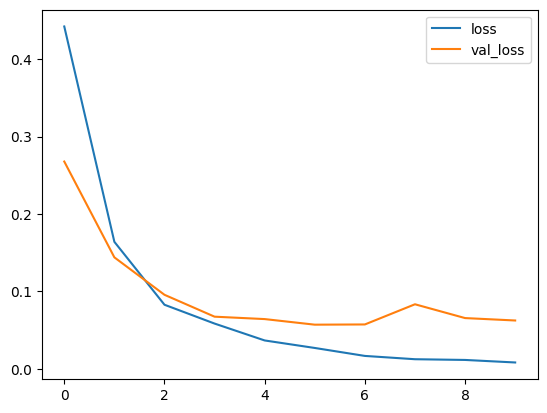

In [ ]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend();

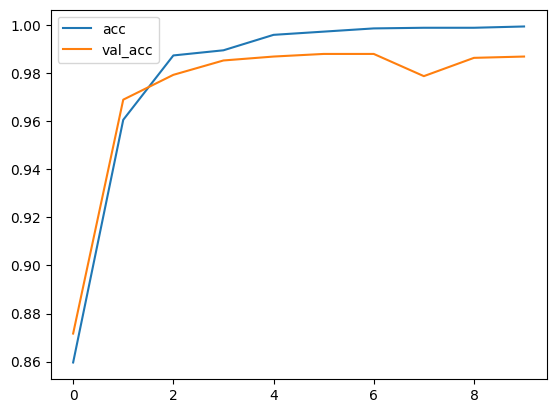

In [ ]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend();

<Axes: >

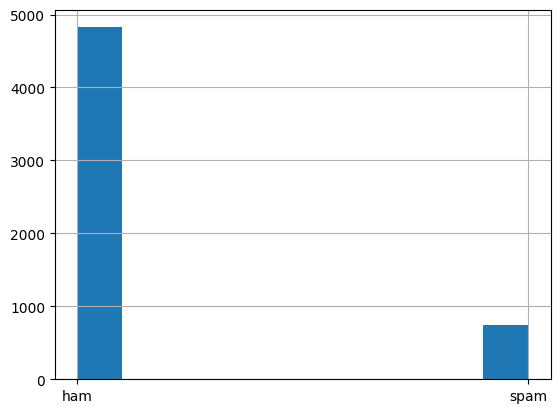

In [ ]:
df['Labels'].hist()

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_train, model.predict(df_train) > 0.5)

117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


0.999000999000999

In [ ]:
f1_score(y_test, model.predict(df_test) > 0.5)

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


0.9512195121951219

In [ ]:
train_ints = vectorization(df_train.values)
test_ints = vectorization(df_test.values)
train_ints.shape, test_ints.shape

(TensorShape([3733, 171]), TensorShape([1839, 162]))

In [ ]:
train_ints[:5]

<tf.Tensor: shape=(5, 171), dtype=int64, numpy=
array([[  60,   40, 1338,   82,   93, 4521,  234,  751,  185,  108,   92,
        3520,  110,  140,    3,  178,  633,  110,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   

In [ ]:
# creat tf datasets
train_ints = tf.data.Dataset.from_tensor_slices((train_ints, y_train))
test_ints = tf.data.Dataset.from_tensor_slices((test_ints, y_test))

In [ ]:
# shuffle and batch the dataset
train_ints = train_ints.shuffle(10000).batch(32).prefetch(tf.data.AUTOTUNE)
test_ints = test_ints.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# create the model
# We get to choose embedding dimensionality
D = 20

# Hidden state dimensionality
M = 15

# if string not specified, will get string ---> float casting error
i = Input(shape=(None,))
x = Embedding(V, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

In [ ]:
# compile and fit the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print('Training the model...')

r = model.fit(train_ints, validation_data=test_ints, epochs=10)

Training the model...
Epoch 1/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.8611 - loss: 0.4867 - val_accuracy: 0.8662 - val_loss: 0.3672
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.8649 - loss: 0.3347 - val_accuracy: 0.8662 - val_loss: 0.2414
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.8898 - loss: 0.2026 - val_accuracy: 0.9761 - val_loss: 0.1678
Epoch 4/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9867 - loss: 0.1439 - val_accuracy: 0.9761 - val_loss: 0.1312
Epoch 5/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.9917 - loss: 0.0890 - val_accuracy: 0.9739 - val_loss: 0.1389
Epoch 6/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.9952 - loss: 0.0925 - val_accuracy: 0.9788 - val_loss: 0.1037
Epoch 7/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.9949 - loss: 0.0621 - val_accuracy: 0.9804 - val_loss: 0.0882
Epoch 8/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.9971 -

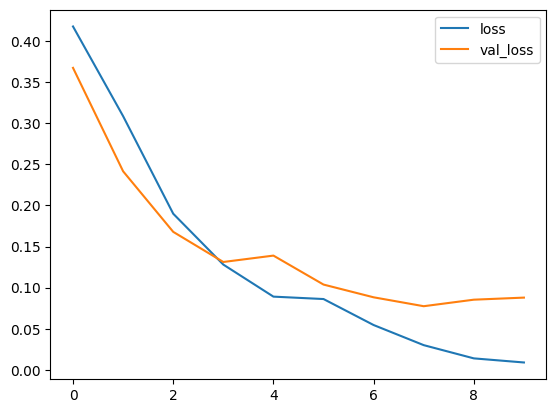

In [ ]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend();

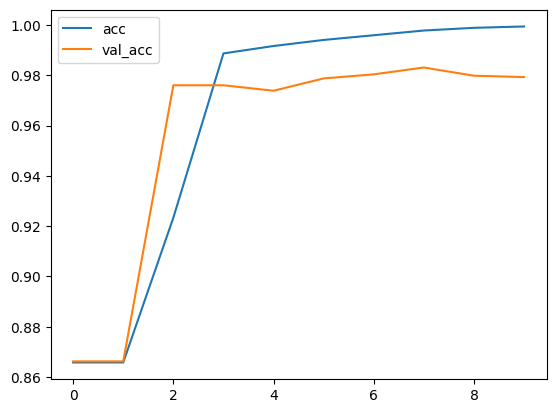

In [ ]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend();